# Integrator Windup

In this notebook you'll explore something called [Integrator Windup](https://en.wikipedia.org/wiki/Integral_windup).

Integrator Windup occurs in a PID controller when a large change in the setpoint happens. This causes the integral term to accumulate a large error (windup) as it rises to the new setpoint. 

Once the system reaches the new setpoint, the large accumulated error will cause the system to overshoot as the accumulated error is "unwound".

In [1]:
from matplotlib import pyplot as plt
import numpy as np

#### TODO 1
In the two cells below you'll find a `Vehicle` class and a `Controller` class. Review the code in these classes before moving on.

In [2]:
class Vehicle:
    """
    A vehicle (maybe a quadrotor) that moves only in the 
    vertical direction. This vehicle has a maximum and minimum
    allowed thrust.
    """
    z = 0.0
    z_dot = 0.0
    m = 1.0
    
    _thrust = 0.0
    _thrust_min = 4.0
    _thrust_max = 50
    
    def advance_state(self, dt):
        z_dot_dot = (self._thrust - self.m*9.81) / self.m
        self.z_dot += z_dot_dot * dt
        self.z += self.z_dot * dt
        
    def set_thrust(self, thrust):
        if thrust > self._thrust_max:
            thrust = self._thrust_max
        if thrust < self._thrust_min:
            thrust = self._thrust_min
        self._thrust = thrust

In [3]:
class Controller():
    """
    PID controller with three tunable parameters.
    """
    
    # accumulated error
    integrated_error = 0.0
    last_err = 0.0
    
    # vehicle params
    vehicle_mass = 1.0
    mass_error = 2.0
    
    def __init__(self, k_P=4.0, k_D=11.0, k_I=0.0):
        self.k_P = k_P
        self.k_D = k_D
        self.k_I = k_I
        print("Using controller with:")
        print(" k_P =", k_P)
        print(" k_I =", k_I)
        print(" k_D =", k_D)
        
    @property
    def mass(self):
        return self.vehicle_mass * self.mass_error
    
    def control(self, z, z_cmd, dt):
        err = z_cmd - z
        err_dot = (err - self.last_err) / dt
        self.integrated_error += err*dt
        
        thrust_cmd = (  self.k_P * err \
                      + self.k_D * err_dot \
                      + self.k_I * self.integrated_error \
                      + self.mass * 9.81)
        self.last_err = err
        return thrust_cmd

#### TODO 2
Run the cell below to visualize the trajectory the vehicle try to fly. Later you can modify this trajectory by adjusting `AMPLITUDE` and `DURATION`. 

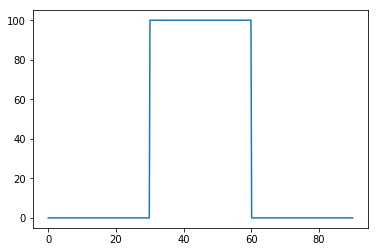

In [4]:
AMPLITUDE = 100
DURATION  = 90.0

trajectory = AMPLITUDE * np.concatenate(
    (np.zeros(150),
     np.ones(150),
     np.zeros(150))
)

t = np.linspace(0, DURATION, trajectory.shape[0])

plt.plot(t, trajectory)

#### TODO 3
Run the following two cells to visualize the vehicle's flight.

In [5]:
def simulate(vehicle, controller, trajectory, t):
    dt = t[1] - t[0]
    hist = []
    for z_cmd in trajectory:
        z = vehicle.z
        hist.append(z)
        thrust_cmd = controller.control(z, z_cmd, dt)
        vehicle.set_thrust(thrust_cmd)
        vehicle.advance_state(dt)
    return hist

Using controller with:
 k_P = 1.0
 k_I = 1.0
 k_D = 4.0


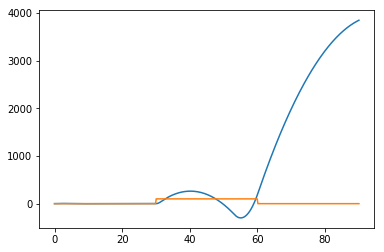

In [10]:
# SIMULATION CELL

k_P = 1.0
k_I = 1.0
k_D = 4.0

controller_1 = Controller(k_P=k_P, k_I=k_I, k_D=k_D)
# controller_2 = WindupAvoidingController(k_P=k_P, k_I=k_I, k_D=k_D)
vehicle_1 = Vehicle()
# vehicle_2 = Vehicle()

hist_1 = simulate(vehicle_1, controller_1, trajectory, t)
# hist_2 = simulate(vehicle_2, controller_2, trajectory, t)
    
plt.plot(t, hist_1)
# plt.plot(t, hist_2)
plt.plot(t, trajectory)

#### TODO 4

Compare different values of `k_I` above. Try 0.0, 0.2, 0.5, 1.0...

* At `k_I = 0.0`, the mass error causes the vehicle to never actually reach the target altitude.

* At `k_I = 0.1`, the vehicle does eventually reach its targets, but it takes a long time.

* At `k_I = 0.2`, you can really start to see how the **integrator windup** causes the vehicle to overshoot.

* At `k_I = 0.5`, the windup causes serious oscillations. But these oscillations appear to eventually die out.

* At `k_I = 1.0`, the integrator has added so much instability that the system is totally unstable. 

This should give you a sense for how winup in the I term adds instability to the system.

----

#### TODO 5

Read the [Wikipedia Article on Integral Windup](https://en.wikipedia.org/wiki/Integral_windup) and try implementing one of the solutions suggested there in the `WindupAvoidingController` class below.

Once you've done that, you can uncomment the lines of code in the cell marked `# SIMULATION CELL` above. Now when you run that cell you'll be able to compare the normal controller to the "windup avoiding" controller.

Using controller with:
 k_P = 1.0
 k_I = 0.7
 k_D = 4.0
Using controller with:
 k_P = 1.0
 k_I = 0.7
 k_D = 4.0


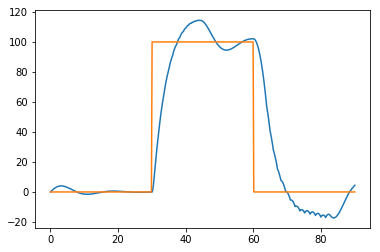

In [30]:
class WindupAvoidingController():
    
    # accumulated error
    integrated_error = 0.0
    last_err = 0.0
    
    # vehicle params
    vehicle_mass = 1.0
    mass_error = 2.0
    
    # NEW vehicle params
    thrust_min = 4.0
    thrust_max = 50
    
    def __init__(self, k_P=4.0, k_D=11.0, k_I=0.0):
        self.k_P = k_P
        self.k_D = k_D
        self.k_I = k_I
        print("Using controller with:")
        print(" k_P =", k_P)
        print(" k_I =", k_I)
        print(" k_D =", k_D)
        
    @property
    def mass(self):
        return self.vehicle_mass * self.mass_error
    
    def control(self, z, z_cmd, dt):
        err = z_cmd - z
        err_dot = (err - self.last_err) / dt
        #self.integrated_error += err*dt

        thrust_cmd = (self.k_P * err \
                      + self.k_D * err_dot \
                      + self.mass * 9.81)

        if self.thrust_min < thrust_cmd < self.thrust_max:
            self.integrated_error += err*dt
            thrust_cmd += self.k_I * self.integrated_error

        self.last_err = err
        return thrust_cmd
# SIMULATION CELL

k_P = 1.0
k_I = 0.7
k_D = 4.0

controller_1 = Controller(k_P=k_P, k_I=k_I, k_D=k_D)
controller_2 = WindupAvoidingController(k_P=k_P, k_I=k_I, k_D=k_D)
vehicle_1 = Vehicle()
vehicle_2 = Vehicle()

hist_1 = simulate(vehicle_1, controller_1, trajectory, t)
hist_2 = simulate(vehicle_2, controller_2, trajectory, t)
    
#plt.plot(t, hist_1)
plt.plot(t, hist_2)
plt.plot(t, trajectory)

#### One Solution

The following code demonstrates one potential windup-avoiding solution:

```python
    def control(self, z, z_cmd, dt):
        err = z_cmd - z
        err_dot = (err - self.last_err) / dt
        self.integrated_error += err*dt
        
        thrust_cmd = (self.k_P * err \
                      + self.k_D * err_dot \
                      + self.mass * 9.81)
        
        if self.thrust_min < thrust_cmd < self.thrust_max:
            self.integrated_error += err*dt
            thrust_cmd += self.k_I * self.integrated_error
        
        self.last_err = err
        return thrust_cmd
```